## Lead Scoring Case Study

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing libraries for data manipulation
import numpy as np
import pandas as pd

# Importing libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
%matplotlib inline

# Set pretty printing format for floats
pd.set_option('float_format', '{:.2f}'.format)

# To view all columns
pd.set_option('display.max_columns', 999)

# For train-test split
from sklearn.model_selection import train_test_split

# For scaling
from sklearn.preprocessing import StandardScaler

# For Stats Model
import statsmodels.api as sm

# For logistic Regression
from sklearn.linear_model import LogisticRegression

# For RFE
from sklearn.feature_selection import RFE

# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For Confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# For precision score and recall score
from sklearn.metrics import precision_score, recall_score

# For Precision-Recall curve
from sklearn.metrics import precision_recall_curve

#### Reading the data into a dataframe

In [2]:
leads_df = pd.read_csv('Leads.csv')

#### Inspecting the data

In [3]:
# Checking the columns, column-types etc.
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

It can be seen that there are a lot of columns where the count of not null values is considerably fewer than the total counts.

In [4]:
# checking for duplicates
leads_df[leads_df.duplicated(subset = 'Prospect ID')]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity


There are no duplicates

In [5]:
# As mentioned in the problem statement, a lot of categorical columns have the value 'Select'. Checking for such counts
select_values = leads_df.isin(['Select']).sum(axis=0)
select_values[~select_values.isin([0])]

Specialization                        1942
How did you hear about X Education    5043
Lead Profile                          4146
City                                  2249
dtype: int64

In [6]:
# Replacing the values 'Select' in categorical columns with nan
leads_df = leads_df.replace('Select', np.nan)

In [7]:
# Columns to drop
cols_to_drop = []

In [8]:
# Checking null values %ages for all the columns
round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)

Prospect ID                                      0.00
Lead Number                                      0.00
Lead Origin                                      0.00
Lead Source                                      0.39
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    1.11
Country                                         26.63
Specialization                                  36.58
How did you hear about X Education              78.46
What is your current occupation                 29.11
What matters most to you in choosing a course   29.32
Search                                           0.00
Magazine                                         0.00
Newspaper Article           

In [9]:
# Columns with more than 70% of the values as null values can be dropped
cols_to_drop.extend(['How did you hear about X Education','Lead Profile'])

#### EDA

We will now inspect the columns one by one

In [10]:
# Lead Origin
leads_df['Lead Origin'].value_counts(dropna=False)

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

Owing to the heterogeneousness of values and no null values, we'll keep this column as it is.

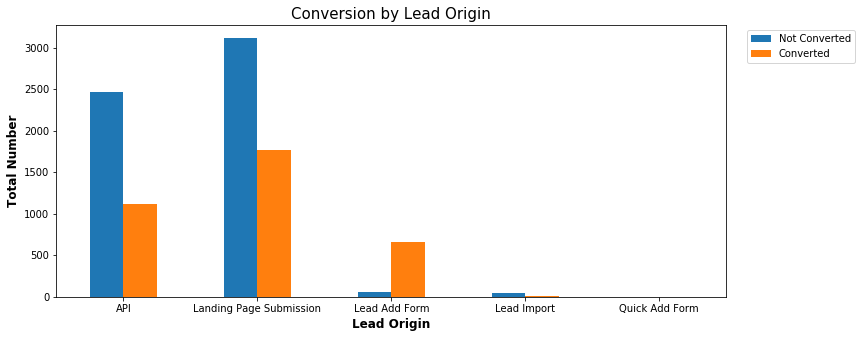

In [11]:
# Plotting for conversion ratio according to 'Lead Origin'
leads_lead_origin_group = leads_df.groupby(['Lead Origin','Converted'])
lead_origin_df = pd.DataFrame(leads_lead_origin_group.Converted.count().unstack())
lead_origin_plot = lead_origin_df.plot(kind='bar',title="Conversion by Lead Origin",figsize=(12,5),rot=0)
_ = lead_origin_plot.title.set_size(15)
_ = lead_origin_plot.legend(['Not Converted','Converted'],bbox_to_anchor=(1.2, 1))
_ = lead_origin_plot.set_xlabel("Lead Origin",fontsize=12,fontweight='bold')
_ = lead_origin_plot.set_ylabel("Total Number",fontsize=12,fontweight='bold')

API and Landing Page Submission have low conversion ratio, but high volume. Lead Add form has very high conversion ratio, but low volume.

In [12]:
# Lead Origin
leads_df['Lead Source'].value_counts(dropna=False)

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Social Media            2
Press_Release           2
Live Chat               2
testone                 1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
Pay per Click Ads       1
NC_EDM                  1
blog                    1
Name: Lead Source, dtype: int64

In [13]:
# Replacing the value 'google' with 'Google'
leads_df['Lead Source'] = leads_df['Lead Source'].replace('google', 'Google')

In [14]:
leads_df[leads_df['Lead Source'].isin(['bing','Click2call','Social Media','Live Chat','Press_Release','blog','WeLearn','testone','youtubechannel','welearnblog_Home','Pay per Click Ads','NC_EDM'])].groupby(['Lead Source','Converted']).Converted.count()

Lead Source        Converted
Click2call         0            1
                   1            3
Live Chat          1            2
NC_EDM             1            1
Pay per Click Ads  0            1
Press_Release      0            2
Social Media       0            1
                   1            1
WeLearn            1            1
bing               0            5
                   1            1
blog               0            1
testone            0            1
welearnblog_Home   0            1
youtubechannel     0            1
Name: Converted, dtype: int64

It can be seen that only 9 leads were converted for these lead sources. We can drop these lead sources since the lead conversion is anyway very small.

In [15]:
# Dropping rows with the above listed Lead Source values
leads_df = leads_df[~leads_df['Lead Source'].isin(['bing','Click2call','Social Media','Live Chat','Press_Release','blog','WeLearn','testone','youtubechannel','welearnblog_Home','Pay per Click Ads','NC_EDM'])]

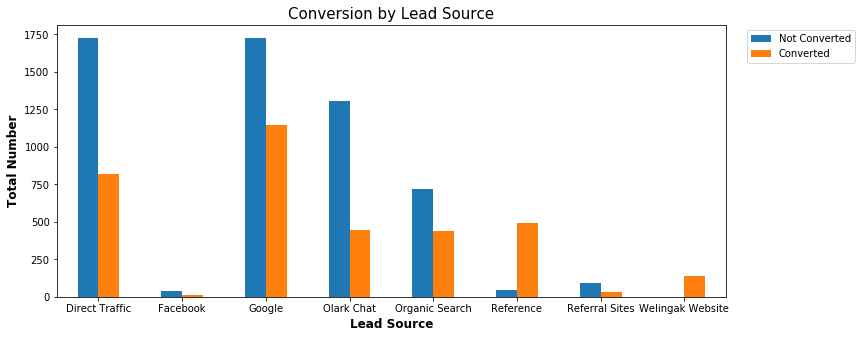

In [16]:
# Plotting for conversion ratio according to 'Lead Source'
leads_lead_source_group = leads_df.groupby(['Lead Source','Converted'])
lead_source_df = pd.DataFrame(leads_lead_source_group.Converted.count().unstack())
lead_source_plot = lead_source_df.plot(kind='bar',title="Conversion by Lead Source",figsize=(12,5),rot=0)
_ = lead_source_plot.title.set_size(15)
_ = lead_source_plot.legend(['Not Converted','Converted'],bbox_to_anchor=(1.2, 1))
_ = lead_source_plot.set_xlabel("Lead Source",fontsize=12,fontweight='bold')
_ = lead_source_plot.set_ylabel("Total Number",fontsize=12,fontweight='bold')

Direct Traffic and Google have high volume of lead conversions. Conversion rates of leads through Reference and Welingak Website are high.

In [17]:
# Do Not Email
leads_df['Do Not Email'].value_counts()

No     8486
Yes     731
Name: Do Not Email, dtype: int64

Text(0, 0.5, 'Total Number')

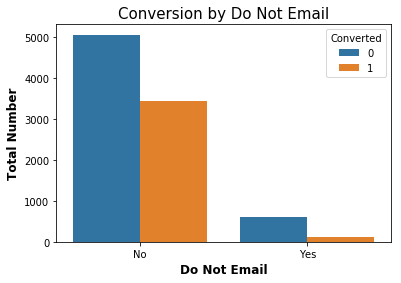

In [18]:
_ = sns.countplot(x = "Do Not Email", hue = "Converted", data = leads_df)
_.set_title('Conversion by Do Not Email', fontsize=15)
_.set_xlabel("Do Not Email",fontsize=12,fontweight='bold')
_.set_ylabel("Total Number",fontsize=12,fontweight='bold')

Leads who select 'Do Not Email' have a high volume of conversion.

'Do Not Email' column can be processed to have 1 for Yes and 0 for No

In [19]:
# Mapping Yes with 1 and No with 0 for 'Do Not Email'
leads_df['Do Not Email'] = leads_df['Do Not Email'].map({"Yes": 1, "No": 0})

In [20]:
# Do Not Call
leads_df['Do Not Call'].value_counts()

No     9215
Yes       2
Name: Do Not Call, dtype: int64

Only 2 values are 'Yes' and rest are 'No'. This column can be dropped.

In [21]:
cols_to_drop.extend(['Do Not Call'])

In [22]:
# TotalVisits
# This is a numeric column, describing it
leads_df.TotalVisits.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   9080.00
mean       3.45
std        4.86
min        0.00
1%         0.00
5%         0.00
10%        0.00
25%        1.00
50%        3.00
75%        5.00
90%        7.00
95%       10.00
99%       17.00
max      251.00
Name: TotalVisits, dtype: float64

It can be observed that there are outliers in this data. Drawing a box plot can help visualize that.

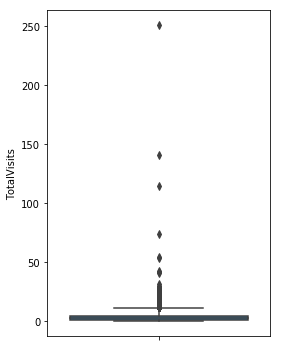

In [23]:
plt.figure(figsize=(4, 6))
sns.boxplot(y= 'TotalVisits', data=leads_df)

This column needs outlier treatment.

In [24]:
cols_with_outlier = []
cols_with_outlier.extend(['TotalVisits'])

In [25]:
# Total Time Spent on Website
# This is a numeric column, describing it
leads_df['Total Time Spent on Website'].describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   9217.00
mean     487.78
std      548.33
min        0.00
1%         0.00
5%         0.00
10%        0.00
25%       12.00
50%      248.00
75%      936.00
90%     1380.00
95%     1562.00
99%     1840.84
max     2272.00
Name: Total Time Spent on Website, dtype: float64

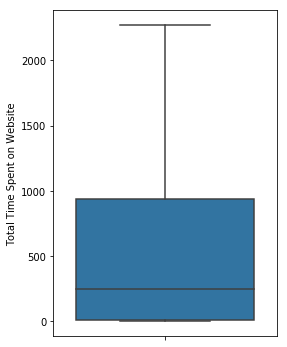

In [26]:
plt.figure(figsize=(4, 6))
sns.boxplot(y= 'Total Time Spent on Website', data=leads_df)

There don't seem to be many outliers here. We can plot this variable with the break down for Converted for visualizing the conversion.

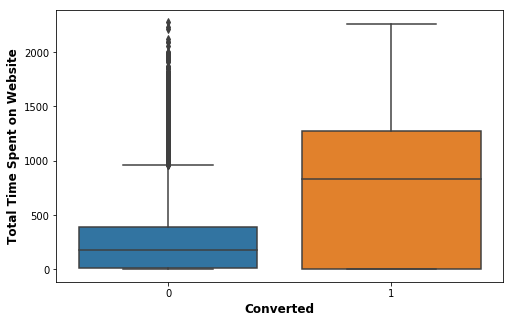

In [27]:
# Plotting loan amount distribution for both types of loans across purposes
plt.figure(figsize=(8, 5))
g = sns.boxplot(y="Total Time Spent on Website", x='Converted', data=leads_df)
_ = g.set_xlabel("Converted",fontsize=12,fontweight='bold')
_ = g.set_ylabel("Total Time Spent on Website",fontsize=12,fontweight='bold')
plt.show()

Leads spending more time on the website are more likely to convert.

In [28]:
# Page Views Per Visit
leads_df['Page Views Per Visit'].describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count   9080.00
mean       2.36
std        2.16
min        0.00
1%         0.00
5%         0.00
10%        0.00
25%        1.00
50%        2.00
75%        3.00
90%        5.00
95%        6.00
99%        9.00
max       55.00
Name: Page Views Per Visit, dtype: float64

This column also has outliers. Plotting a box-plot for visualisation.

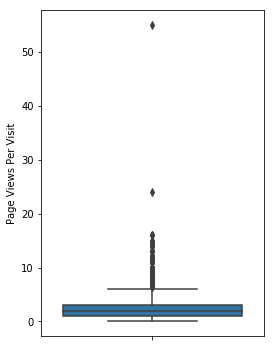

In [29]:
plt.figure(figsize=(4, 6))
sns.boxplot(y= 'Page Views Per Visit', data=leads_df)

This column needs outlier treatment.

In [30]:
cols_with_outlier.extend(['Page Views Per Visit'])

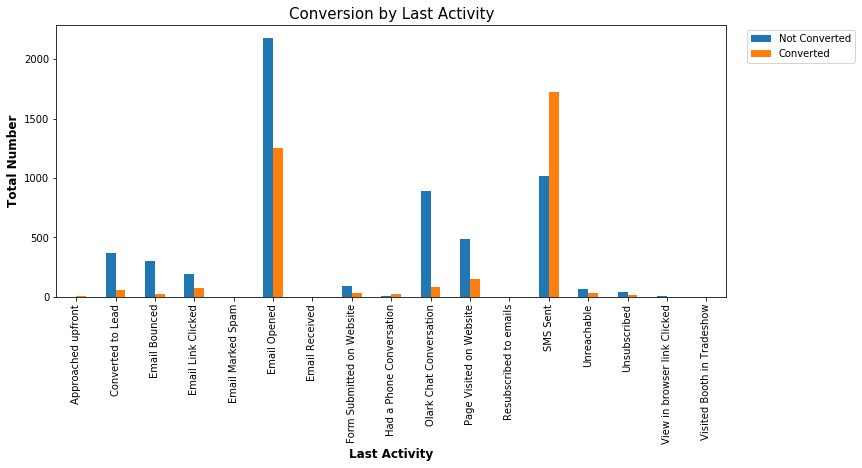

In [31]:
# Last Activity, Plotting to check conversion
leads_last_activity_group = leads_df.groupby(['Last Activity','Converted'])
lead_act_df = pd.DataFrame(leads_last_activity_group.Converted.count().unstack())
lead_act_plot = lead_act_df.plot(kind='bar',title="Conversion by Last Activity",figsize=(12,5),rot=90)
_ = lead_act_plot.title.set_size(15)
_ = lead_act_plot.legend(['Not Converted','Converted'],bbox_to_anchor=(1.2, 1))
_ = lead_act_plot.set_xlabel("Last Activity",fontsize=12,fontweight='bold')
_ = lead_act_plot.set_ylabel("Total Number",fontsize=12,fontweight='bold')

Conversion rate for 'SMS Sent' is the highest. Email Opened last activity generate most number of leads.

In [32]:
# Country
leads_df.Country.value_counts(dropna=False)

India                   6475
NaN                     2456
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Germany                    4
Kuwait                     4
Nigeria                    4
South Africa               4
Canada                     3
Sweden                     3
China                      2
Netherlands                2
Bangladesh                 2
Italy                      2
Belgium                    2
Philippines                2
Ghana                      2
Uganda                     2
Asia/Pacific Region        2
Kenya                      1
Sri Lanka                  1
Russia                     1
Malaysia                   1
Denmark                    1
Indonesia     

Out of total 9240 records, only 6779 are not null. Out of 6779 not null values, 6475 are India.
<br>This means only 3.3% of total and about 4.5% of not null records are countries other than India.
<br>This column can be dropped since it's not adding much information.

In [33]:
cols_to_drop.extend(['Country'])

In [34]:
# Specialization
leads_df.Specialization.value_counts(dropna=False)

NaN                                  3374
Finance Management                    975
Human Resource Management             843
Marketing Management                  836
Operations Management                 501
Business Administration               401
IT Projects Management                366
Supply Chain Management               347
Banking, Investment And Insurance     338
Media and Advertising                 202
Travel and Tourism                    201
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

In [35]:
# Replacing null values with 'Others'
leads_df['Specialization'] = leads_df.Specialization.replace(np.nan, 'Others')

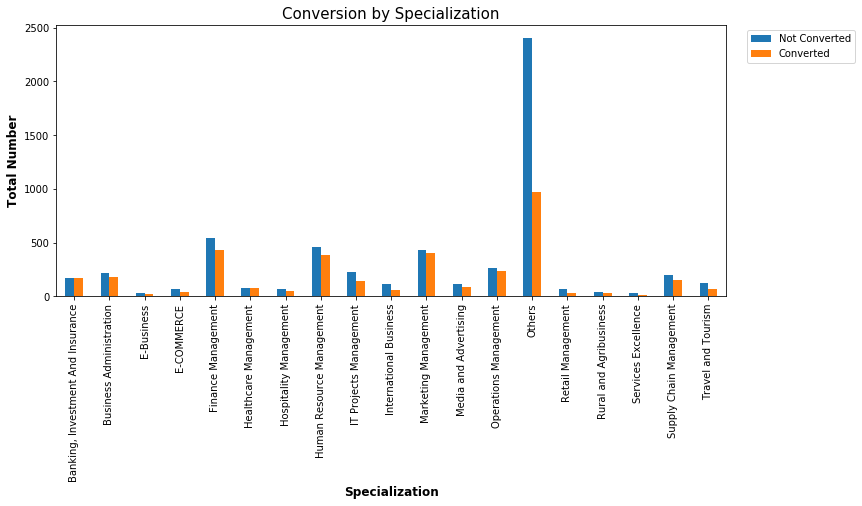

In [36]:
# Plotting for Conversion by Specialization
leads_specialization_group = leads_df.groupby(['Specialization','Converted'])
lead_spec_df = pd.DataFrame(leads_specialization_group.Converted.count().unstack())
lead_spec_plot = lead_spec_df.plot(kind='bar',title="Conversion by Specialization",figsize=(12,5),rot=90)
_ = lead_spec_plot.title.set_size(15)
_ = lead_spec_plot.legend(['Not Converted','Converted'],bbox_to_anchor=(1.2, 1))
_ = lead_spec_plot.set_xlabel("Specialization",fontsize=12,fontweight='bold')
_ = lead_spec_plot.set_ylabel("Total Number",fontsize=12,fontweight='bold')

In [37]:
# What is your current occupation
leads_df['What is your current occupation'].value_counts(dropna=False)

Unemployed              5585
NaN                     2682
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [38]:
leads_df.groupby(['What is your current occupation','Converted']).Converted.count()

What is your current occupation  Converted
Businessman                      0               3
                                 1               5
Housewife                        1              10
Other                            0               6
                                 1              10
Student                          0             132
                                 1              78
Unemployed                       0            3152
                                 1            2433
Working Professional             0              59
                                 1             647
Name: Converted, dtype: int64

Around 60% of total and 85% of not null values are 'Unemployed. Imputing the null values with a new category, "Unspecified".

In [39]:
leads_df['What is your current occupation'] = leads_df['What is your current occupation'].replace(np.nan, 'Unspecified')

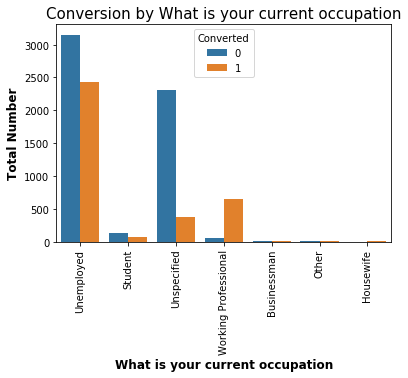

In [40]:
# Plotting for conversion by 'What is your current occupation'
_ = sns.countplot(x = "What is your current occupation", hue = "Converted", data = leads_df)
_.set_title('Conversion by What is your current occupation', fontsize=15)
_.set_xlabel("What is your current occupation",fontsize=12,fontweight='bold')
xticks(rotation = 90)
__ = _.set_ylabel("Total Number",fontsize=12,fontweight='bold')

In [41]:
# What matters most to you in choosing a course
leads_df['What matters most to you in choosing a course'].value_counts(dropna=False)

Better Career Prospects      6513
NaN                          2701
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

~70% values are 'Better Career Prospects' and rest are null. This column can be dropped.

In [42]:
cols_to_drop.extend(['What matters most to you in choosing a course'])

In [43]:
# Search
leads_df.Search.value_counts(dropna=False)

No     9203
Yes      14
Name: Search, dtype: int64

Almost ~100% values are 'No'. This column isn't adding much information and hence can be dropped.

In [44]:
cols_to_drop.extend(['Search'])

In [45]:
# Magazine
leads_df.Magazine.value_counts(dropna=False)

No    9217
Name: Magazine, dtype: int64

All the values are No. This column isn't adding much information and hence can be dropped.

In [46]:
cols_to_drop.extend(['Magazine'])

In [47]:
# Newspaper Article
leads_df['Newspaper Article'].value_counts(dropna=False)

No     9215
Yes       2
Name: Newspaper Article, dtype: int64

All except 2 values are No. This column isn't adding much information and hence can be dropped.

In [48]:
cols_to_drop.extend(['Newspaper Article'])

In [49]:
# X Education Forums
leads_df['X Education Forums'].value_counts(dropna=False)

No     9216
Yes       1
Name: X Education Forums, dtype: int64

All except 1 values are No. This column isn't adding much information and hence can be dropped.

In [50]:
cols_to_drop.extend(['X Education Forums'])

In [51]:
# Newspaper
leads_df['Newspaper'].value_counts(dropna=False)

No     9216
Yes       1
Name: Newspaper, dtype: int64

All except 1 values are No. This column isn't adding much information and hence can be dropped.

In [52]:
cols_to_drop.extend(['Newspaper'])

In [53]:
# Digital Advertisement
leads_df['Digital Advertisement'].value_counts(dropna=False)

No     9213
Yes       4
Name: Digital Advertisement, dtype: int64

This column isn't adding much information and hence can be dropped.

In [54]:
cols_to_drop.extend(['Digital Advertisement'])

In [55]:
# Through Recommendations
leads_df['Through Recommendations'].value_counts(dropna=False)

No     9210
Yes       7
Name: Through Recommendations, dtype: int64

All except 7 values are No. This column isn't adding much information and hence can be dropped.

In [56]:
cols_to_drop.extend(['Through Recommendations'])

In [57]:
# Receive More Updates About Our Courses
leads_df['Receive More Updates About Our Courses'].value_counts(dropna=False)

No    9217
Name: Receive More Updates About Our Courses, dtype: int64

All values are No. This column isn't adding much information and hence can be dropped.

In [58]:
cols_to_drop.extend(['Receive More Updates About Our Courses'])

In [59]:
# Tags
leads_df['Tags'].value_counts(dropna=False)

NaN                                                  3343
Will revert after reading the email                  2066
Ringing                                              1202
Interested in other courses                           512
Already a student                                     462
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           144
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with 

In [60]:
# There are a lot of null values, imputing them with 'Unspecified'
leads_df['Tags'] = leads_df['Tags'].replace(np.nan, 'Unspecified')

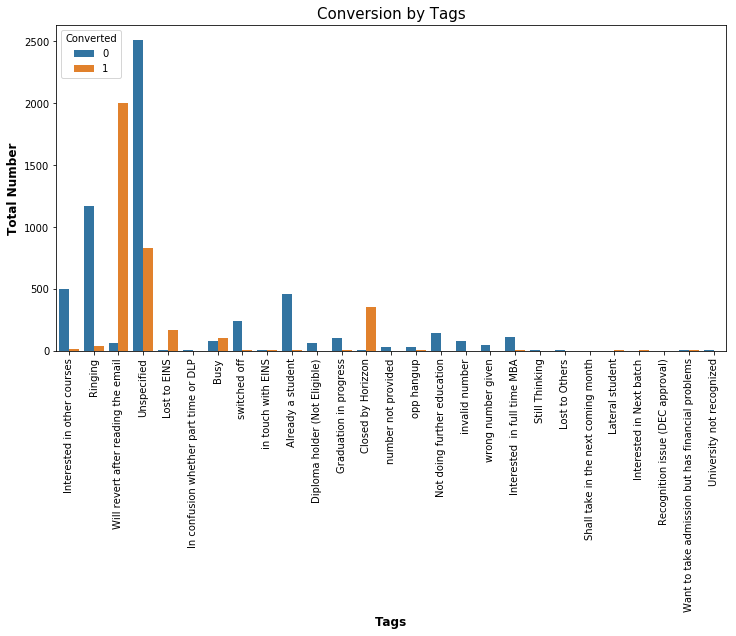

In [61]:
# Plotting for conversion by 'What is your current occupation'
plt.figure(figsize=(12, 6))
_ = sns.countplot(x = "Tags", hue = "Converted", data = leads_df)
_.set_title('Conversion by Tags', fontsize=15)
_.set_xlabel("Tags",fontsize=12,fontweight='bold')
xticks(rotation = 90)
__ = _.set_ylabel("Total Number",fontsize=12,fontweight='bold')

There are some categories like University not recognized, Recognition issue (DEC approval), Lost to Others, wrong number given, number not provided, invalid number etc which almost never convert

In [62]:
# Lead Quality
leads_df['Lead Quality'].value_counts(dropna=False)

NaN                  4754
Might be             1557
Not Sure             1090
High in Relevance     636
Worst                 599
Low in Relevance      581
Name: Lead Quality, dtype: int64

There are null values. Null can be replaced with 'Unspecified', which is equivalent to Not Sure.
<br>Replacing null values with 'Not Sure'

In [63]:
leads_df['Lead Quality'] = leads_df['Lead Quality'].replace(np.nan, 'Not Sure')

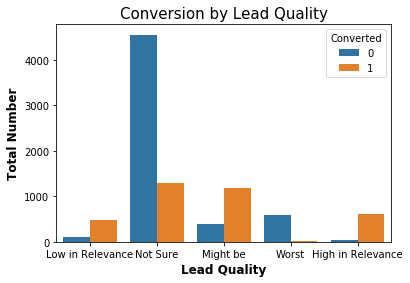

In [64]:
# Plotting for conversion by Lead Quality
_ = sns.countplot(x = "Lead Quality", hue = "Converted", data = leads_df)
_.set_title('Conversion by Lead Quality', fontsize=15)
_.set_xlabel("Lead Quality",fontsize=12,fontweight='bold')
__ = _.set_ylabel("Total Number",fontsize=12,fontweight='bold')

Might be has the highest Conversion ratio. Low in Relevance and High in Relevance have more Converted leads than not Converted. Rest types have low conversion ratio.

In [65]:
# Update me on Supply Chain Content
leads_df['Update me on Supply Chain Content'].value_counts()

No    9217
Name: Update me on Supply Chain Content, dtype: int64

All values are No. This column isn't adding much information and hence can be dropped.

In [66]:
cols_to_drop.extend(['Update me on Supply Chain Content'])

In [67]:
# Get updates on DM Content
leads_df['Get updates on DM Content'].value_counts()

No    9217
Name: Get updates on DM Content, dtype: int64

All values are No. This column isn't adding much information and hence can be dropped.

In [68]:
cols_to_drop.extend(['Get updates on DM Content'])

In [69]:
# City
leads_df['City'].value_counts(dropna=False)

NaN                            3660
Mumbai                         3214
Thane & Outskirts               748
Other Cities                    685
Other Cities of Maharashtra     456
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

In [70]:
# There are a lot of null values, imputing them with 'Unspecified'
leads_df['City'] = leads_df['City'].replace(np.nan, 'Unspecified')

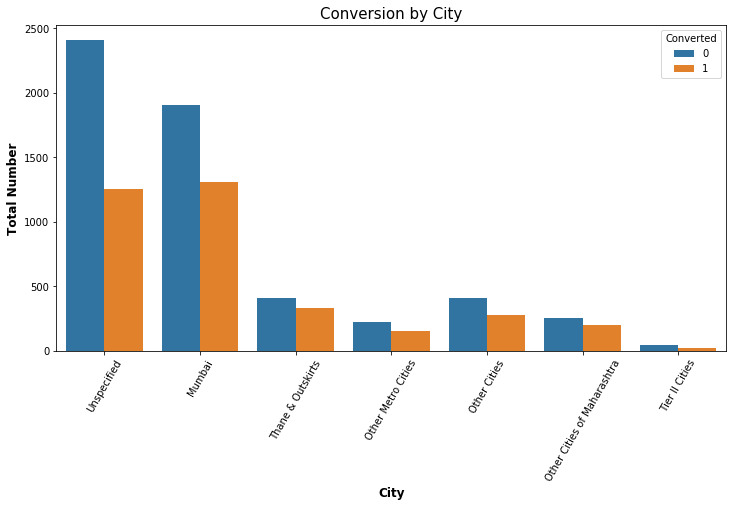

In [71]:
# Plotting for conversion by 'What is your current occupation'
plt.figure(figsize=(12, 6))
_ = sns.countplot(x = "City", hue = "Converted", data = leads_df)
_.set_title('Conversion by City', fontsize=15)
_.set_xlabel("City",fontsize=12,fontweight='bold')
xticks(rotation = 60)
__ = _.set_ylabel("Total Number",fontsize=12,fontweight='bold')

Following columns have 45.65% values as null values
<br>Asymmetrique Activity Index
<br>Asymmetrique Profile Index 
<br>Asymmetrique Activity Score
<br>Asymmetrique Profile Score

In [72]:
# Asymmetrique Activity Index
leads_df.groupby(['Asymmetrique Activity Index','Converted']).Converted.count()

Asymmetrique Activity Index  Converted
01.High                      0             574
                             1             243
02.Medium                    0            2204
                             1            1626
03.Low                       0             329
                             1              33
Name: Converted, dtype: int64

In [73]:
# Asymmetrique Profile Index
leads_df.groupby(['Asymmetrique Profile Index','Converted']).Converted.count()

Asymmetrique Profile Index  Converted
01.High                     0            1155
                            1            1042
02.Medium                   0            1937
                            1             845
03.Low                      0              15
                            1              15
Name: Converted, dtype: int64

In [74]:
# Asymmetrique Activity Score
leads_df.groupby(['Asymmetrique Activity Score','Converted']).Converted.count()

Asymmetrique Activity Score  Converted
7.00                         0               1
8.00                         0               4
9.00                         0               9
10.00                        0              54
                             1               3
11.00                        0              88
                             1               7
12.00                        0             173
                             1              23
13.00                        0             677
                             1              98
14.00                        0            1058
                             1             709
15.00                        0             469
                             1             819
16.00                        0             239
                             1             226
17.00                        0             331
                             1              17
18.00                        0               4
Name: Converted, dtyp

In [75]:
# Asymmetrique Activity Score
leads_df.groupby(['Asymmetrique Profile Score','Converted']).Converted.count()

Asymmetrique Profile Score  Converted
11.00                       0               4
                            1               5
12.00                       0              11
                            1              10
13.00                       0             156
                            1              48
14.00                       0             169
                            1              56
15.00                       0            1258
                            1             500
16.00                       0             354
                            1             241
17.00                       0             316
                            1             259
18.00                       0             687
                            1             383
19.00                       0              62
                            1             182
20.00                       0              90
                            1             218
Name: Converted, dtype: int64

These columns can be dropped.

In [76]:
cols_to_drop.extend(['Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score','Asymmetrique Profile Score'])

In [77]:
# I agree to pay the amount through cheque
leads_df['I agree to pay the amount through cheque'].value_counts()

No    9217
Name: I agree to pay the amount through cheque, dtype: int64

All values are No. This column isn't adding much information and hence can be dropped.

In [78]:
cols_to_drop.extend(['I agree to pay the amount through cheque'])

In [79]:
# A free copy of Mastering The Interview
leads_df['A free copy of Mastering The Interview'].value_counts()

No     6333
Yes    2884
Name: A free copy of Mastering The Interview, dtype: int64

The categorical values can be mapped as 1 for Yes and 0 for No

In [80]:
leads_df['A free copy of Mastering The Interview'] = leads_df['A free copy of Mastering The Interview'].map({"Yes": 1, "No": 0})

In [81]:
# Last Notable Activity
leads_df['Last Notable Activity'].value_counts()

Modified                        3399
Email Opened                    2818
SMS Sent                        2169
Page Visited on Website          316
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      46
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Email Received                     1
View in browser link Clicked       1
Form Submitted on Website          1
Approached upfront                 1
Resubscribed to emails             1
Name: Last Notable Activity, dtype: int64

In [82]:
leads_df.groupby(['Last Notable Activity','Converted']).Converted.count()

Last Notable Activity         Converted
Approached upfront            1               1
Email Bounced                 0              51
                              1               9
Email Link Clicked            0             128
                              1              45
Email Marked Spam             1               2
Email Opened                  0            1778
                              1            1040
Email Received                1               1
Form Submitted on Website     0               1
Had a Phone Conversation      0               1
                              1              13
Modified                      0            2617
                              1             782
Olark Chat Conversation       0             158
                              1              25
Page Visited on Website       0             224
                              1              92
Resubscribed to emails        1               1
SMS Sent                      0             664


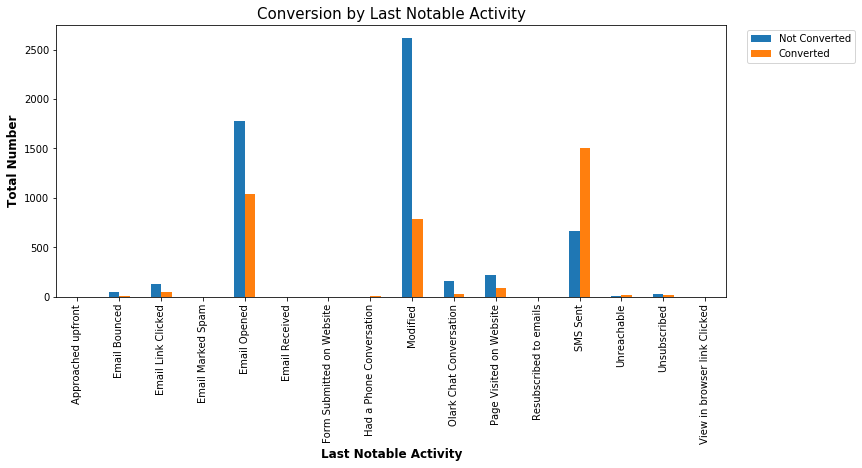

In [83]:
# Plotting for conversion by Last Notable Activity
leads_lna_group = leads_df.groupby(['Last Notable Activity','Converted'])
lead_lna_df = pd.DataFrame(leads_lna_group.Converted.count().unstack())
lead_lna_plot = lead_lna_df.plot(kind='bar',title="Conversion by Last Notable Activity",figsize=(12,5),rot=90)
_ = lead_lna_plot.title.set_size(15)
_ = lead_lna_plot.legend(['Not Converted','Converted'],bbox_to_anchor=(1.2, 1))
_ = lead_lna_plot.set_xlabel("Last Notable Activity",fontsize=12,fontweight='bold')
_ = lead_lna_plot.set_ylabel("Total Number",fontsize=12,fontweight='bold')

After the above analysis, dropping the columns which aren't adding much information.

In [84]:
leads_df.drop(columns=cols_to_drop, axis=1, inplace=True)

Performing outlier treatment for columns with outliers. Using 5th percentile for lower bound and 95th percentile for upper bound.

In [85]:
for col in cols_with_outlier:
    quantile_5th = leads_df[col].quantile(0.05)
    quantile_95th = leads_df[col].quantile(0.95)
    leads_df[col][leads_df[col] <= quantile_5th] = quantile_5th
    leads_df[col][leads_df[col] >= quantile_95th] = quantile_95th

In [86]:
# Checking again for the null value percentages
round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)

Prospect ID                              0.00
Lead Number                              0.00
Lead Origin                              0.00
Lead Source                              0.39
Do Not Email                             0.00
Converted                                0.00
TotalVisits                              1.49
Total Time Spent on Website              0.00
Page Views Per Visit                     1.49
Last Activity                            1.12
Specialization                           0.00
What is your current occupation          0.00
Tags                                     0.00
Lead Quality                             0.00
City                                     0.00
A free copy of Mastering The Interview   0.00
Last Notable Activity                    0.00
dtype: float64

In [87]:
# Null values now are very few in number. These can be dropped.
leads_df.dropna(inplace = True)

Overall Conversion rate

In [88]:
conversion = (sum(leads_df['Converted'])/len(leads_df['Converted'].index))*100
conversion

37.85217103082532

The overall conversion is around 38%

#### Creating Dummy Variables

In [89]:
# Dummy variables can be created for all the categorical columns
cols_dummies = ['Lead Origin','Lead Source','Last Activity','Specialization','What is your current occupation','Tags','Lead Quality','City','Last Notable Activity']
leads_dummies = pd.get_dummies(leads_df[cols_dummies],drop_first=True)
leads_df = pd.concat([leads_df, leads_dummies], axis=1)
leads_df.drop(cols_dummies,axis=1,inplace=True)
leads_df.head()

,Prospect ID,Lead Number,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unspecified,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Unspecified,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,City_Unspecified,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,0,0,0.00,0,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,0,0,5.00,674,2.50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,0,1,2.00,1532,2.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

#### Splitting the data into train set and test set

In [90]:
# Putting feature variable to X
x = leads_df.drop(['Prospect ID', 'Lead Number','Converted'], axis=1)
y = leads_df['Converted']

# Splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=100)

#### Feature scaling

In [91]:
# 'TotalVisits','Total Time Spent on Website', are 'Page Views Per Visit' continous variables. They have to be scaled.

scaler = StandardScaler()
x_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(x_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
x_train.head()

C:\Users\H253015\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\H253015\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unspecified,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Unspecified,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,City_Unspecified,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
4045,0,-0.43,-0.40,-0.15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1615,0,-1.15,-0.89,-1.27,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2928,0,-0.43,-0.08,-0.15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Model Building

#### Feature selection using RFE

In [92]:
lr = LogisticRegression()
# running RFE with 15 variables
rfe = RFE(lr, 15)
rfe = rfe.fit(x_train, y_train)

In [93]:
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', False, 8),
 ('TotalVisits', False, 40),
 ('Total Time Spent on Website', False, 5),
 ('Page Views Per Visit', False, 41),
 ('A free copy of Mastering The Interview', False, 47),
 ('Lead Origin_Landing Page Submission', False, 32),
 ('Lead Origin_Lead Add Form', False, 4),
 ('Lead Origin_Lead Import', False, 62),
 ('Lead Source_Facebook', False, 43),
 ('Lead Source_Google', False, 88),
 ('Lead Source_Olark Chat', False, 6),
 ('Lead Source_Organic Search', False, 69),
 ('Lead Source_Reference', False, 66),
 ('Lead Source_Referral Sites', False, 42),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Converted to Lead', False, 26),
 ('Last Activity_Email Bounced', False, 24),
 ('Last Activity_Email Link Clicked', False, 81),
 ('Last Activity_Email Marked Spam', False, 80),
 ('Last Activity_Email Opened', False, 60),
 ('Last Activity_Email Received', False, 90),
 ('Last Activity_Form Submitted on Website', False, 72),
 ('Last Activity_Had a Phone Conversation', 

In [94]:
rfe_cols = x_train.columns[rfe.support_]
rfe_cols

Index(['Lead Source_Welingak Website', 'Last Activity_SMS Sent',
       'What is your current occupation_Unspecified', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Ringing',
       'Tags_Unspecified', 'Tags_Will revert after reading the email',
       'Tags_invalid number', 'Tags_number not provided', 'Tags_switched off',
       'Tags_wrong number given', 'Lead Quality_Worst',
       'Last Notable Activity_Modified'],
      dtype='object')

In [95]:
# dropping the columns not selected by RFE
col = x_train.columns[~rfe.support_]
x_train = x_train.drop(col,1)

Creating Model using statsmodel for columns selected by RFE

In [96]:
x_train_sm = sm.add_constant(x_train)
lr2 = sm.GLM(y_train,x_train_sm, family = sm.families.Binomial())
res = lr2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6335
Model:                            GLM   Df Residuals:                     6319
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1247.8
Date:                Sun, 09 Jun 2019   Deviance:                       2495.7
Time:                        20:07:32   Pearson chi2:                 1.17e+04
No. Iterations:                    23   Covariance Type:             nonrobust
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -2.8112      0.207    -13.570      0.000      -3.217      -2.405
Lead Source_Welingak Website                    3.1796      1.024      3.104      0.002       1.172       5.188
Last Activity_SMS Sent                          2.2232      0.120     18.534      0.000       1.988       2.458
What is your current occupation_Unspecified    -2.4944      0.142    -17.527      0.000      -2.773      -2.215
Tags_Busy                                       2.0741      0.295      7.031      0.000       1.496       2.652
Tags_Closed by Horizzon                         8.4027      0.744     11.296      0.000       6.945       9.861
Tags_Lost to EINS                               8.8588      0.651     13.607      0.000       7.583      10.135
Tags_Ringing                                   -1.9773      0.303     -6.525      0.000      -2.571      -1.383
Tags_Unspecified                                3.1704      0.231     13.714      0.000       2.717       3.623
Tags_Will revert after reading the email        6.2634      0.264     23.720      0.000       5.746       6.781
Tags_invalid number                            -1.8883      1.050     -1.798      0.072      -3.947       0.170
Tags_number not provided                      -22.7732   2.74e+04     -0.001      0.999   -5.37e+04    5.37e+04
Tags_switched off                              -2.5223      0.627     -4.024      0.000      -3.751      -1.294
Tags_wrong number given                       -22.6549   1.89e+04     -0.001      0.999   -3.71e+04    3.71e+04
Lead Quality_Worst                             -2.1823      0.721     -3.028      0.002      -3.595      -0.770
Last Notable Activity_Modified                 -1.5735      0.126    -12.442      0.000      -1.821      -1.326
===============================================================================================================
"""

In [97]:
# Checking the VIF values
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
0,Lead Source_Welingak Website,1.12
5,Tags_Lost to EINS,1.06
4,Tags_Closed by Horizzon,1.05
3,Tags_Busy,1.04
11,Tags_switched off,1.04
9,Tags_invalid number,1.01
12,Tags_wrong number given,1.01
10,Tags_number not provided,1.00
13,Lead Quality_Worst,0.42
2,What is your current occupation_Unspecified,0.21


'Tags_wrong number given' has a very high P-Value. Dropping this column and building model again.

In [98]:
x_train_sm.drop('Tags_wrong number given', axis=1, inplace=True)
lr2 = sm.GLM(y_train,x_train_sm, family = sm.families.Binomial())
res = lr2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6335
Model:                            GLM   Df Residuals:                     6320
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1253.2
Date:                Sun, 09 Jun 2019   Deviance:                       2506.3
Time:                        20:07:44   Pearson chi2:                 1.15e+04
No. Iterations:                    22   Covariance Type:             nonrobust
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -2.9819      0.209    -14.290      0.000      -3.391      -2.573
Lead Source_Welingak Website                    3.1812      1.024      3.106      0.002       1.174       5.188
Last Activity_SMS Sent                          2.1885      0.119     18.419      0.000       1.956       2.421
What is your current occupation_Unspecified    -2.4844      0.142    -17.540      0.000      -2.762      -2.207
Tags_Busy                                       2.2611      0.294      7.700      0.000       1.686       2.837
Tags_Closed by Horizzon                         8.5573      0.745     11.489      0.000       7.098      10.017
Tags_Lost to EINS                               9.0039      0.652     13.808      0.000       7.726      10.282
Tags_Ringing                                   -1.7781      0.301     -5.911      0.000      -2.368      -1.188
Tags_Unspecified                                3.3427      0.232     14.404      0.000       2.888       3.798
Tags_Will revert after reading the email        6.4276      0.266     24.199      0.000       5.907       6.948
Tags_invalid number                            -1.6969      1.049     -1.618      0.106      -3.753       0.359
Tags_number not provided                      -21.5780   1.67e+04     -0.001      0.999   -3.27e+04    3.26e+04
Tags_switched off                              -2.3213      0.626     -3.711      0.000      -3.547      -1.095
Lead Quality_Worst                             -2.1130      0.726     -2.910      0.004      -3.536      -0.690
Last Notable Activity_Modified                 -1.5540      0.126    -12.313      0.000      -1.801      -1.307
===============================================================================================================
"""

In [99]:
# Checking the VIF values again
x_train.drop('Tags_wrong number given', axis=1, inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
0,Lead Source_Welingak Website,1.12
5,Tags_Lost to EINS,1.06
4,Tags_Closed by Horizzon,1.05
3,Tags_Busy,1.04
11,Tags_switched off,1.03
9,Tags_invalid number,1.01
10,Tags_number not provided,1.00
12,Lead Quality_Worst,0.42
2,What is your current occupation_Unspecified,0.21
13,Last Notable Activity_Modified,0.15


In [100]:
# Iteratively dropping columns with high p-value and checking VIFs
x_train_sm.drop('Tags_number not provided', axis=1, inplace=True)
lr2 = sm.GLM(y_train,x_train_sm, family = sm.families.Binomial())
res = lr2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6335
Model:                            GLM   Df Residuals:                     6321
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1255.7
Date:                Sun, 09 Jun 2019   Deviance:                       2511.4
Time:                        20:07:48   Pearson chi2:                 1.14e+04
No. Iterations:                     8   Covariance Type:             nonrobust
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -3.0648      0.209    -14.656      0.000      -3.475      -2.655
Lead Source_Welingak Website                    3.1820      1.024      3.108      0.002       1.175       5.189
Last Activity_SMS Sent                          2.1745      0.118     18.364      0.000       1.942       2.407
What is your current occupation_Unspecified    -2.4804      0.141    -17.546      0.000      -2.758      -2.203
Tags_Busy                                       2.3503      0.293      8.022      0.000       1.776       2.924
Tags_Closed by Horizzon                         8.6319      0.745     11.583      0.000       7.171      10.092
Tags_Lost to EINS                               9.0745      0.653     13.906      0.000       7.795      10.354
Tags_Ringing                                   -1.6837      0.300     -5.617      0.000      -2.271      -1.096
Tags_Unspecified                                3.4258      0.232     14.745      0.000       2.970       3.881
Tags_Will revert after reading the email        6.5069      0.266     24.441      0.000       5.985       7.029
Tags_invalid number                            -1.6068      1.049     -1.532      0.125      -3.662       0.448
Tags_switched off                              -2.2263      0.625     -3.562      0.000      -3.451      -1.001
Lead Quality_Worst                             -2.0740      0.729     -2.845      0.004      -3.503      -0.645
Last Notable Activity_Modified                 -1.5441      0.126    -12.242      0.000      -1.791      -1.297
===============================================================================================================
"""

In [101]:
# Checking the VIF values again
x_train.drop('Tags_number not provided', axis=1, inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
0,Lead Source_Welingak Website,1.12
5,Tags_Lost to EINS,1.06
4,Tags_Closed by Horizzon,1.05
3,Tags_Busy,1.04
10,Tags_switched off,1.03
9,Tags_invalid number,1.01
11,Lead Quality_Worst,0.42
2,What is your current occupation_Unspecified,0.21
12,Last Notable Activity_Modified,0.15
1,Last Activity_SMS Sent,0.12


In [102]:
x_train_sm.drop('Tags_invalid number', axis=1, inplace=True)
lr2 = sm.GLM(y_train,x_train_sm, family = sm.families.Binomial())
res = lr2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6335
Model:                            GLM   Df Residuals:                     6322
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1257.5
Date:                Sun, 09 Jun 2019   Deviance:                       2515.1
Time:                        20:07:53   Pearson chi2:                 1.12e+04
No. Iterations:                     8   Covariance Type:             nonrobust
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -3.1694      0.207    -15.331      0.000      -3.575      -2.764
Lead Source_Welingak Website                    3.1827      1.024      3.109      0.002       1.176       5.189
Last Activity_SMS Sent                          2.1615      0.118     18.323      0.000       1.930       2.393
What is your current occupation_Unspecified    -2.4769      0.141    -17.554      0.000      -2.753      -2.200
Tags_Busy                                       2.4606      0.290      8.479      0.000       1.892       3.029
Tags_Closed by Horizzon                         8.7293      0.745     11.719      0.000       7.269      10.189
Tags_Lost to EINS                               9.1703      0.652     14.062      0.000       7.892      10.448
Tags_Ringing                                   -1.5686      0.297     -5.290      0.000      -2.150      -0.987
Tags_Unspecified                                3.5306      0.230     15.347      0.000       3.080       3.982
Tags_Will revert after reading the email        6.6086      0.265     24.964      0.000       6.090       7.127
Tags_switched off                              -2.1103      0.623     -3.385      0.001      -3.332      -0.888
Lead Quality_Worst                             -2.1231      0.727     -2.922      0.003      -3.547      -0.699
Last Notable Activity_Modified                 -1.5345      0.126    -12.174      0.000      -1.782      -1.287
===============================================================================================================
"""

In [103]:
# Checking the VIF values again
x_train.drop('Tags_invalid number', axis=1, inplace=True)
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
0,Lead Source_Welingak Website,1.12
5,Tags_Lost to EINS,1.06
4,Tags_Closed by Horizzon,1.05
3,Tags_Busy,1.04
9,Tags_switched off,1.03
10,Lead Quality_Worst,0.42
2,What is your current occupation_Unspecified,0.21
11,Last Notable Activity_Modified,0.15
1,Last Activity_SMS Sent,0.12
8,Tags_Will revert after reading the email,0.11


#### All the VIF values are below 5 and P-values are also ~0. This model can be used for prediction.

In [104]:
# Function to Print prediction related metrics
def model_performance(x,y):
    print('Overall Accuracy: '+ str(metrics.accuracy_score(x, y)))

    # Confusion matrix 
    confusion = metrics.confusion_matrix(x, y)
    print('Confusion Matrix: ')
    print(confusion)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    # Sensitivity
    print('Sensitivity: '+str(TP / float(TP+FN)))

    # Specificity
    print('Specificity: '+str(TN / float(TN+FP)))

    # Calculate False Postive Rate
    print('False Positive Rate: '+str(FP/ float(TN+FP)))

    # Positive Predictive Value 
    print('Positive Predictive Value: '+str(TP / float(TP+FP)))

    # Negative predictive value
    print('Negative Predictive Value: '+str(TN / float(TN+ FN)))

    #### Precision and Recall

    # Precision
    print('Precision: '+str(TP /(TP + FP)))

    # Recall
    print('Recall: '+str(TP / (TP + FN)))

#### Making Predictions on the train set

In [105]:
# Getting the predicted values on the train set
y_train_pred = res.predict(x_train_sm)

In [106]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred.values.reshape(-1)})

# This will be used later to merge the lease score back to the original dataset
y_train_pred_final['Merge ID'] = y_train.index
# Taking cut-off probability as 0.5
y_train_pred_final['Converted_pred'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final = y_train_pred_final.reindex_axis(['Merge ID','Converted','Converted_prob','Converted_pred'], axis=1)
y_train_pred_final.head()

,Merge ID,Converted,Converted_prob,Converted_pred
0,4045,0,0.07,0
1,1615,1,0.93,1
2,2928,0,0.11,0
3,1238,0,0.03,0
4,6985,0,0.11,0


In [107]:
# Checking prediction related metrics for cut-off probability 0.5
model_performance(y_train_pred_final.Converted,y_train_pred_final.Converted_pred)

Overall Accuracy: 0.9294396211523284
Confusion Matrix: 
[[3681  242]
 [ 205 2207]]
Sensitivity: 0.9150082918739635
Specificity: 0.938312515931685
False Positive Rate: 0.06168748406831506
Positive Predictive Value: 0.9011841567986933
Negative Predictive Value: 0.947246525990736
Precision: 0.9011841567986933
Recall: 0.9150082918739635


#### Plotting the ROC Curve

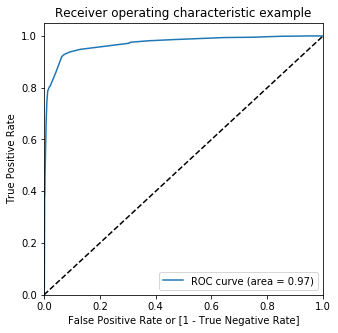

In [108]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_prob, drop_intermediate = False )

draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

#### Finding Optimal Cutoff Point

      prob  accuracy  sensi  speci
0.00  0.00      0.38   1.00   0.00
0.10  0.10      0.80   0.97   0.70
0.20  0.20      0.92   0.94   0.91
0.30  0.30      0.93   0.93   0.93
0.40  0.40      0.93   0.92   0.94
0.50  0.50      0.93   0.92   0.94
0.60  0.60      0.91   0.81   0.98
0.70  0.70      0.91   0.81   0.98
0.80  0.80      0.91   0.80   0.98
0.90  0.90      0.89   0.73   0.99


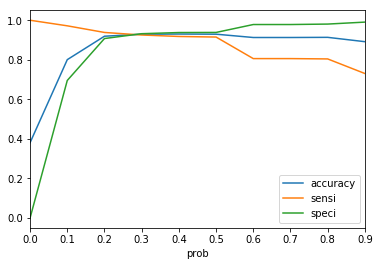

In [109]:
# Creating columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

# Calculating accuracy, sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

# Plotting accuracy, sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [110]:
y_train_pred_final['Converted_pred_0.3'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.3 else 0)
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis=1,inplace=True)
y_train_pred_final.head()

,Merge ID,Converted,Converted_prob,Converted_pred,Converted_pred_0.3
0,4045,0,0.07,0,0
1,1615,1,0.93,1,1
2,2928,0,0.11,0,0
3,1238,0,0.03,0,0
4,6985,0,0.11,0,0


In [111]:
# Checkint the prediction related metrics when cut-off probability is taken as 0.3
model_performance(y_train_pred_final.Converted, y_train_pred_final['Converted_pred_0.3'])

Overall Accuracy: 0.9294396211523284
Confusion Matrix: 
[[3656  267]
 [ 180 2232]]
Sensitivity: 0.9253731343283582
Specificity: 0.9319398419576854
False Positive Rate: 0.06806015804231455
Positive Predictive Value: 0.8931572629051621
Negative Predictive Value: 0.9530761209593326
Precision: 0.8931572629051621
Recall: 0.9253731343283582


#### Precision and recall tradeoff

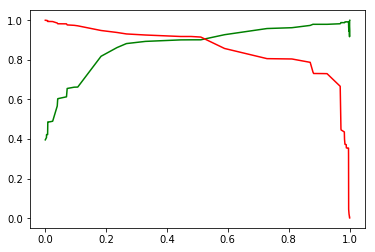

In [112]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

Precision-Recall Curve gives an optimal probability of ~0.55

In [113]:
# Printing prediction related metrics using probability 0.55
y_train_pred_final['Converted_pred_0.55'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.55 else 0)

model_performance(y_train_pred_final.Converted, y_train_pred_final['Converted_pred_0.55'])

Overall Accuracy: 0.9199684293606946
Confusion Matrix: 
[[3760  163]
 [ 344 2068]]
Sensitivity: 0.857379767827529
Specificity: 0.9584501656895233
False Positive Rate: 0.04154983431047667
Positive Predictive Value: 0.9269385925593904
Negative Predictive Value: 0.9161793372319688
Precision: 0.9269385925593904
Recall: 0.857379767827529


#### Above are the metrics for the train data.

#### Making predictions on the test set

In [114]:
# Applying scaling on the continous variables in test data
x_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(x_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

C:\Users\H253015\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [115]:
x_test = x_test[x_train.columns]
x_test.head()

,Lead Source_Welingak Website,Last Activity_SMS Sent,What is your current occupation_Unspecified,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_Ringing,Tags_Unspecified,Tags_Will revert after reading the email,Tags_switched off,Lead Quality_Worst,Last Notable Activity_Modified
4741,0,0,1,0,0,0,0,1,0,0,0,1
3786,0,0,0,0,0,0,0,0,1,0,0,0
7432,0,1,0,0,0,0,0,0,1,0,0,0
8416,0,0,0,0,0,0,1,0,0,0,0,0
998,0,0,0,0,0,0,1,0,0,0,0,0


In [116]:
x_test_sm = sm.add_constant(x_test)

In [117]:
y_test_pred = res.predict(x_test_sm)
y_test_pred[:10]

4741   0.03
3786   0.97
7432   1.00
8416   0.01
998    0.01
2315   1.00
7078   0.11
8759   0.93
7701   0.11
6375   0.98
dtype: float64

In [118]:
# Converting y_pred to a dataframe which is an array
y_test_pred = pd.DataFrame(y_test_pred)

# # Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# # This will be used later to merge the lease score back to the original dataset
y_test_df['Merge ID'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_test_pred.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# # Concatenating y_test_df and y_pred_1
y_pred_test = pd.concat([y_test_df, y_test_pred],axis=1)

y_pred_test= y_pred_test.rename(columns={ 0 : 'Converted_prob'})

# Using 0.55 as cut-off probability (as given by precision-recall trade-off) since it gives a better precision
y_pred_test['Converted_pred_0.55'] = y_pred_test.Converted_prob.map(lambda x: 1 if x > 0.55 else 0)

y_pred_test = y_pred_test.reindex_axis(['Merge ID','Converted','Converted_prob','Converted_pred_0.55'], axis=1)

y_pred_test.head()

,Merge ID,Converted,Converted_prob,Converted_pred_0.55
0,4741,0,0.03,0
1,3786,1,0.97,1
2,7432,1,1.00,1
3,8416,0,0.01,0
4,998,0,0.01,0


In [119]:
# Printing prediction related metrics
model_performance(y_pred_test.Converted, y_pred_test['Converted_pred_0.55'])

Overall Accuracy: 0.927098674521355
Confusion Matrix: 
[[1636   66]
 [ 132  882]]
Sensitivity: 0.8698224852071006
Specificity: 0.9612220916568742
False Positive Rate: 0.038777908343125736
Positive Predictive Value: 0.930379746835443
Negative Predictive Value: 0.9253393665158371
Precision: 0.930379746835443
Recall: 0.8698224852071006


#### Above are the metrics on the test data.

#### Assigning Lead Score

In [120]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.Converted_prob.map( lambda x: round(x*100))
y_pred_test['Lead_Score'] = y_pred_test.Converted_prob.map( lambda x: round(x*100))

In [121]:
y_train_pred_final.head()

,Merge ID,Converted,Converted_prob,Converted_pred,Converted_pred_0.3,Converted_pred_0.55,Lead_Score
0,4045,0,0.07,0,0,0,7
1,1615,1,0.93,1,1,1,93
2,2928,0,0.11,0,0,0,11
3,1238,0,0.03,0,0,0,3
4,6985,0,0.11,0,0,0,11


In [122]:
y_pred_test.head()

,Merge ID,Converted,Converted_prob,Converted_pred_0.55,Lead_Score
0,4741,0,0.03,0,3
1,3786,1,0.97,1,97
2,7432,1,1.00,1,100
3,8416,0,0.01,0,1
4,998,0,0.01,0,1


In [123]:
y_merged = y_train_pred_final[['Merge ID','Converted_prob','Converted_pred_0.55','Lead_Score']].append(y_pred_test[['Merge ID','Converted_prob','Converted_pred_0.55','Lead_Score']])
y_merged = y_merged.rename(columns={ 'Converted_pred_0.55' : 'Converted_predicted'})
y_merged.head()

,Merge ID,Converted_prob,Converted_predicted,Lead_Score
0,4045,0.07,0,7
1,1615,0.93,1,93
2,2928,0.11,0,11
3,1238,0.03,0,3
4,6985,0.11,0,11


Merging the output with main dataset, leads_df

In [126]:
leads_df['Merge ID'] = leads_df.index

In [127]:
leads_df = pd.merge(leads_df,y_merged,how='inner',on='Merge ID')

In [128]:
leads_df[['Prospect ID', 'Lead Number', 'Converted', 'Lead_Score','Converted_predicted']].head()

,Prospect ID,Lead Number,Converted,Lead_Score,Converted_predicted
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,0,1,0
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,0,1,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,1,97,1
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,0,0,0
4,3256f628-e534-4826-9d63-4a8b88782852,660681,1,87,1


In [132]:
# Checking the percentage of incorrect predictions
len(leads_df[leads_df.Converted != leads_df.Converted_predicted])/len(leads_df)

0.07789194564136559